In [14]:
from kimport import *
import corona as cr
import gootools as gt

irdap_main_path = "D:/Science/LBV/test_irdap" 

---
### Photometry

---

In [19]:
stars   = np.array([
    [*cr.load_preprocessed(name)] for name in cr.targets
])
image,error = stars[1,:]

In [23]:
from photutils.detection import DAOStarFinder
daofind = DAOStarFinder(fwhm=5.,threshold=3*error.mean()) 
sources = daofind(image)
x,y = np.array(sources['xcentroid']),np.array(sources['ycentroid'])

In [24]:
from photutils.aperture import aperture_photometry, CircularAperture
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=10.)  
phot_table = aperture_photometry(image,apertures)  
phot_table

id,xcenter,ycenter,aperture_sum
,pix,pix,
int32,float64,float64,float64
1,422.57865095713174,16.743976949228244,6425.990862987666
2,425.94841110152356,84.0297483732271,38072.78303837405
3,328.33223157690117,299.2256478610972,5646.200170539851
4,469.39445370714947,444.09761126048767,293378.59303817997
5,509.0601411617814,446.46504430995174,387217.60770144826
6,499.69888557451605,445.6969128380978,385178.03846854286
7,480.8497121901185,447.05591380463244,351778.13554752804
8,534.0452107572953,447.35327825761397,331222.8666506541


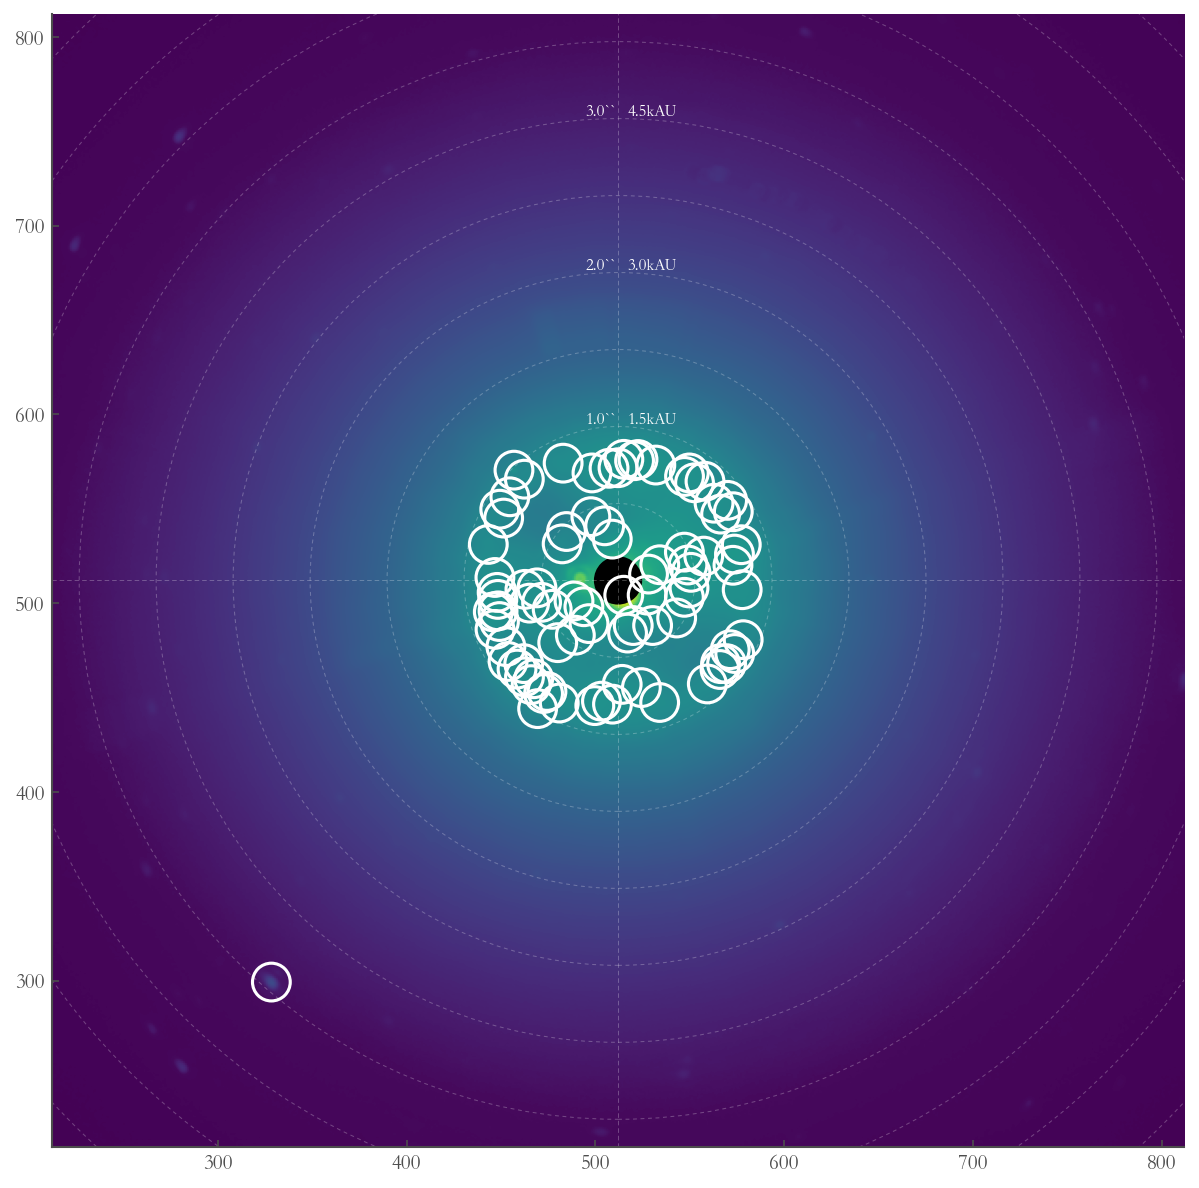

In [25]:
fig,ax = plt.subplots(1,figsize=(10,10))
cr.lbv_show(fig,ax,image,'AS-314')
apertures.plot(color='white',zorder=1000,lw=1.5,axes=ax)
cr.center_lim(ax,300)

---
### Chance Alignment
---
Ok! Better idea from Kathryn!!!
 * make a map of the objects around the target (say 2 arcmins?)
 * take the LBV and move it to a random point within that map
 * determine how many stars we would see around the LBV --- factoring contrast curves and whatnot into account --- within 1, 2, 3, ect. arcseconds
 * monte carlo it!
 
 
## Problem: i think 2mass isn't deep enough :-(

In [ ]:
v = Vizier()
v.ROW_LIMIT = 100_000
radius = 2 #arcminutes
search_targets = ['AS 314','HD 160529','HD 168607','HD 168625','HD 316285','HD 326823','MWC 314','Zeta01 Sco']

In [ ]:
contrast = lambda r : (6/2.3)*(r-.2)+9 # contrast curve for H band coronagraphy with sphere irdis
r_limit  = lambda c : (2.3/6)*(c-9)+.2 # at what radius sphere/irdis achieves contrast c
def random_shift(coordinates,min_shift,max_shift,N):
    min_shift,max_shift = min_shift.to(u.deg).value,max_shift.to(u.deg).value
    position_angle = np.random.rand(N)*360*u.deg
    separation = (np.random.rand(N)*(max_shift-min_shift)+min_shift)*u.deg
    return coordinates.directional_offset_by(position_angle,separation)
def is_visible(target_coordinates,feild_coordinates,target_H,feild_H):
    r = target_coordinates.separation(field_coordinates).arcsec
    contrast_limit = contrast(r) + target_H
    is_visible = np.array([True if h > contrast_limit else False for h in feild_H])
    return is_visible

In [ ]:
class Binary_Probability():
    def __init__(self,target,search_radius=2,N=10_000):
        self.name               = target
        self.N                  = N #number of runs
        self.target_coordinates = SkyCoord.from_name(self.name)
        self.target_H           = cr.target_H_flux[self.name]
        self.field_stars        = v.query_region(
            self.target_coordinates,
            inner_radius=.5*u.arcmin,
            radius=search_radius*u.arcmin,
            catalog='2MASS'
        )[0]
        
        if self.name == 'HD 168625':
            del self.field_stars[0] #this row is the only one that lacks an H-band value
        
        [ra,dec,self.field_H]   = np.array([[row["RAJ2000"],row["DEJ2000"],row['Hmag']]    for row in self.field_stars]).T
        self.field_coordinates  = SkyCoord(ra*u.deg,dec*u.deg)
        self.max_r              = 5*u.arcsec
        shift_buffer            = self.max_r.to(u.arcmin) #to make sure we don't shift directly to the edge of our search radius
        
        self.offset_coordinates = random_shift(
            self.target_coordinates,
            .5*u.arcmin+shift_buffer,
            search_radius*u.arcmin-shift_buffer,
            N
        )
        self.separations        = np.array([
            coord.separation(self.field_coordinates).arcsec for coord in self.offset_coordinates
        ])
        
    def is_visible(self,r,H):
        contrast_limit = contrast(r) + self.target_H
        return H < contrast_limit
    
    def find_false_alarms(self,r):
        false_alarms = np.array([
            len(run[np.where((run<r)&self.is_visible(run,self.field_H))])    for run in self.separations
        ])
        return false_alarms
    
    def chance_alignment(self,r,n_star):
        """
        computes the probability of finding n_stars within r arcseconds of the target, based on the simulation above
        """
        if type(r)==float:
            r = np.array([r])
        false_alarms = np.array([self.find_false_alarms(x)    for x in r])
        return np.array([len(fa[fa>=n_star])*100/self.N    for fa in false_alarms])
    
    def plot_map(self,ax=None,**kwargs):
        if ax==None:
            fig,ax = plt.subplots(1,**kwargs)
        ax.scatter(self.field_coordinates.ra.deg,self.field_coordinates.dec.deg,color='black',s=2)
        ax.scatter(self.target_coordinates.ra.deg,self.target_coordinates.dec.deg,color='red',marker='*')
        ax.set_title(self.name)
        ax.grid()

In [ ]:
prob_objects = [Binary_Probability(name,N=100) for name in search_targets]

In [ ]:
x = np.linspace(.2,2,100)
for Obj in prob_objects:
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    ax1.plot(x,Obj.chance_alignment(x,1))
    ax1.axhline(5,color='black',linestyle='--')
    ax1.axhline(.3,color='black',linestyle='--')
    ax1.axvline(r_limit(15.1-Obj.target_H),color='blue')
    ax1.set_title(Obj.name)
    ax1.set_yscale('log')
    ax1.set_ylim(.1,7)
    Obj.plot_map(ax=ax2)
    plt.show()

---